# Data

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load full dataset - changed from dataset_original.csv to dataset.csv to resolve FileNotFoundError
df_full = pd.read_csv('drive/MyDrive/ai/dataset_original.csv')
print("Successfully loaded dataset.csv")

print("=== FULL DATASET ===")
print(f"Total rows: {len(df_full):,}")
print(f"Total activities: {df_full['activity_name'].nunique()}")
print(f"Total subjects: {df_full['subject_file'].nunique()}")
print(f"  Columns: {len(df_full.columns)}")

# Stratified sampling - keeps ALL 13 activities proportionally
df_sampled, _ = train_test_split(
    df_full,
    train_size=0.07,  # 5% sample (adjust as needed: 0.05=5%, 0.10=10%)
    stratify=df_full['activity_name'],  # Maintains activity proportions
    random_state=42  # For reproducibility
)

print("\n=== SAMPLED DATASET ===")
print(f"Sampled rows: {len(df_sampled):,}")
print(f"Sampled activities: {df_sampled['activity_name'].nunique()}")
print(f"Sampled subjects: {df_sampled['subject_file'].nunique()}")

# Verify all activities are present
print("\n=== Activity Distribution in Sample ===")
print(df_sampled['activity_name'].value_counts().sort_index())

# Clean missing values
print("\n=== CLEANING ===")
print(f"Before - Missing heart_rate: {df_sampled['heart_rate'].isnull().sum()}")
print(f"Before - Missing hand_temperature: {df_sampled['hand_temperature'].isnull().sum()}")

# Clean heart rate and temperature with mean
df_sampled['heart_rate'] = df_sampled['heart_rate'].fillna(df_sampled['heart_rate'].mean())
df_sampled['hand_temperature'] = df_sampled['hand_temperature'].fillna(df_sampled['hand_temperature'].mean())

print(f"After - Missing heart_rate: {df_sampled['heart_rate'].isnull().sum()}")
print(f"After - Missing hand_temperature: {df_sampled['hand_temperature'].isnull().sum()}")

# Clean ankle orientation features
orientation_cols = ['ankle_orientation_1', 'ankle_orientation_2',
                    'ankle_orientation_3', 'ankle_orientation_4']

print("\n=== ANKLE ORIENTATION CLEANING ===")
# Check missing values in orientation columns
for col in orientation_cols:
    missing = df_sampled[col].isnull().sum()
    print(f"Before - Missing {col}: {missing}")

# Calculate total missing percentage
total_orientation_missing = df_sampled[orientation_cols].isnull().sum().sum()
total_orientation_cells = len(df_sampled) * len(orientation_cols)
missing_percent = (total_orientation_missing / total_orientation_cells) * 100

print(f"\nTotal missing orientation values: {total_orientation_missing:,} ({missing_percent:.2f}%)")

# Sort by timestamp for forward fill (important for time-series data)
df_sampled = df_sampled.sort_values('timestamp').reset_index(drop=True)

# Strategy based on missing percentage
if missing_percent < 1:
    # Very few missing - drop rows with any missing orientation
    print("\nStrategy: Dropping rows with missing orientations (< 1% missing)")
    rows_before = len(df_sampled)
    df_sampled = df_sampled.dropna(subset=orientation_cols)
    rows_dropped = rows_before - len(df_sampled)
    print(f"Dropped {rows_dropped:,} rows")

elif missing_percent < 10:
    # Some missing - use forward/backward fill
    print("\nStrategy: Forward/backward fill for orientations (< 10% missing)")
    for col in orientation_cols:
        df_sampled[col] = df_sampled[col].fillna(method='ffill')
        df_sampled[col] = df_sampled[col].fillna(method='bfill')
        # If still any missing, use identity quaternion
        if col == 'ankle_orientation_1':
            df_sampled[col] = df_sampled[col].fillna(1.0)
        else:
            df_sampled[col] = df_sampled[col].fillna(0.0)
    print("Forward/backward fill completed")

else:
    # Too many missing - drop orientation features
    print("\nStrategy: Dropping orientation features (> 10% missing)")
    df_sampled = df_sampled.drop(columns=orientation_cols)
    print(f"Dropped {len(orientation_cols)} orientation columns")

# Verify cleaning
if set(orientation_cols).issubset(df_sampled.columns):
    print("\nAfter cleaning:")
    for col in orientation_cols:
        missing = df_sampled[col].isnull().sum()
        print(f"After - Missing {col}: {missing}")
else:
    print("\nOrientation features were removed from dataset")

# Save the clean sampled dataset
df_sampled.to_csv('drive/MyDrive/ai/dataset_sampled_clean.csv', index=False)

print(f"\n✓ Sampled & cleaned dataset saved!")
print(f"  File: dataset_sampled_clean.csv")
print(f"  Rows: {len(df_sampled):,}")
print(f"  Activities: {df_sampled['activity_name'].nunique()}/13")
print(f"  Columns: {len(df_sampled.columns)}")

Successfully loaded dataset.csv
=== FULL DATASET ===
Total rows: 2,872,533
Total activities: 13
Total subjects: 9
  Columns: 56

=== SAMPLED DATASET ===
Sampled rows: 201,077
Sampled activities: 13
Sampled subjects: 9

=== Activity Distribution in Sample ===
activity_name
Nordic_walking       13168
ascending_stairs      8205
cycling              11522
descending_stairs     7346
ironing              16708
lying                13477
other                65076
rope_jumping          3455
running               6874
sitting              12963
standing             13295
vacuum_cleaning      12275
walking              16713
Name: count, dtype: int64

=== CLEANING ===
Before - Missing heart_rate: 182693
Before - Missing hand_temperature: 941
After - Missing heart_rate: 0
After - Missing hand_temperature: 0

=== ANKLE ORIENTATION CLEANING ===
Before - Missing ankle_orientation_1: 802
Before - Missing ankle_orientation_2: 802
Before - Missing ankle_orientation_3: 802
Before - Missing ankle_orient

In [ ]:
import pandas as pd
# full_df = pd.read_csv('drive/MyDrive/ai/dataset_original.csv') # This file seems to be missing
df = pd.read_csv('drive/MyDrive/ai/dataset.csv')

TASK 1.4: DUPLICATES & OUTLIERS DETECTION

### PART 1: DUPLICATE DETECTION ###

Complete duplicate rows: 0
✓ No complete duplicate rows found

Duplicate sensor readings (excluding timestamp): 0

### Checking for duplicates by activity and subject ###
Duplicate timestamp-subject-activity combinations: 0


### PART 2: OUTLIER DETECTION ###

Analyzing 52 numeric features for outliers

### TOP 10 FEATURES WITH MOST OUTLIERS ###
       Feature  Outlier_Count  Outlier_Percent        Min       Max
ankle_acc16g_x          50455        35.275076  -66.30850 154.99200
 ankle_acc6g_x          50134        35.050653  -61.30230  61.98610
  ankle_gyro_z          46651        32.615550  -10.60300  12.27730
  ankle_gyro_x          43827        30.641181  -10.23080  11.99220
  ankle_gyro_y          40083        28.023603   -7.70104   5.31820
   hand_gyro_z          33729        23.581271  -13.25670  12.79840
   hand_gyro_y          26044        18.208385  -11.16330  10.85130
ankle_acc16g_y          2581

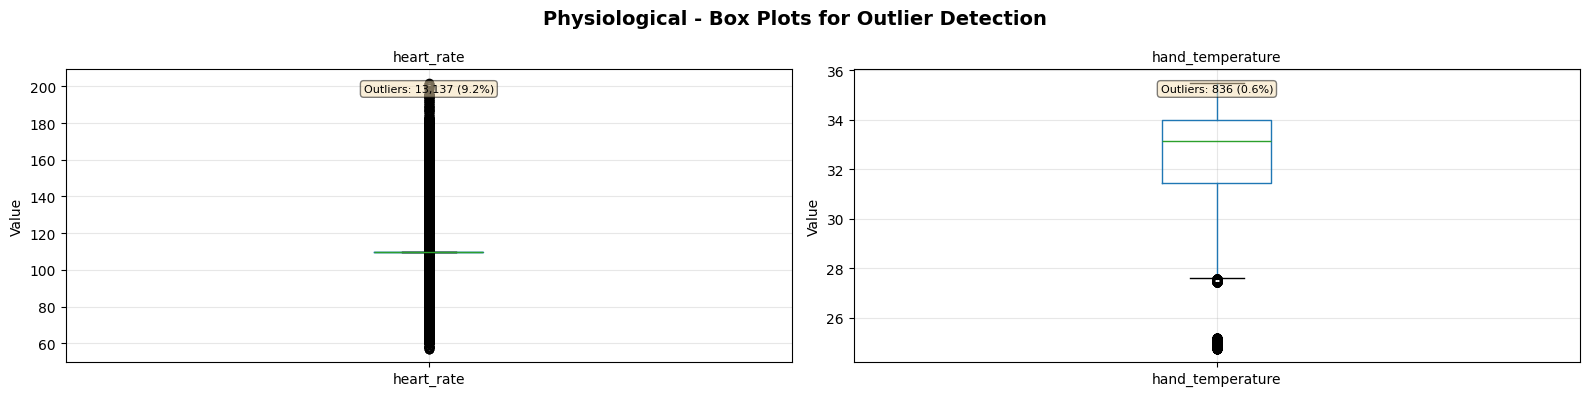

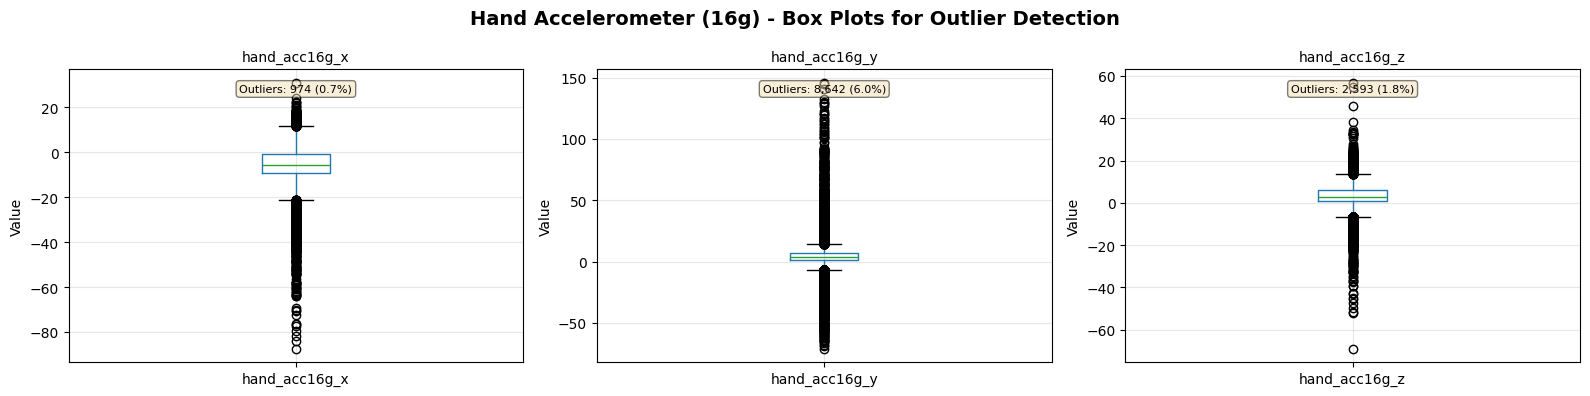

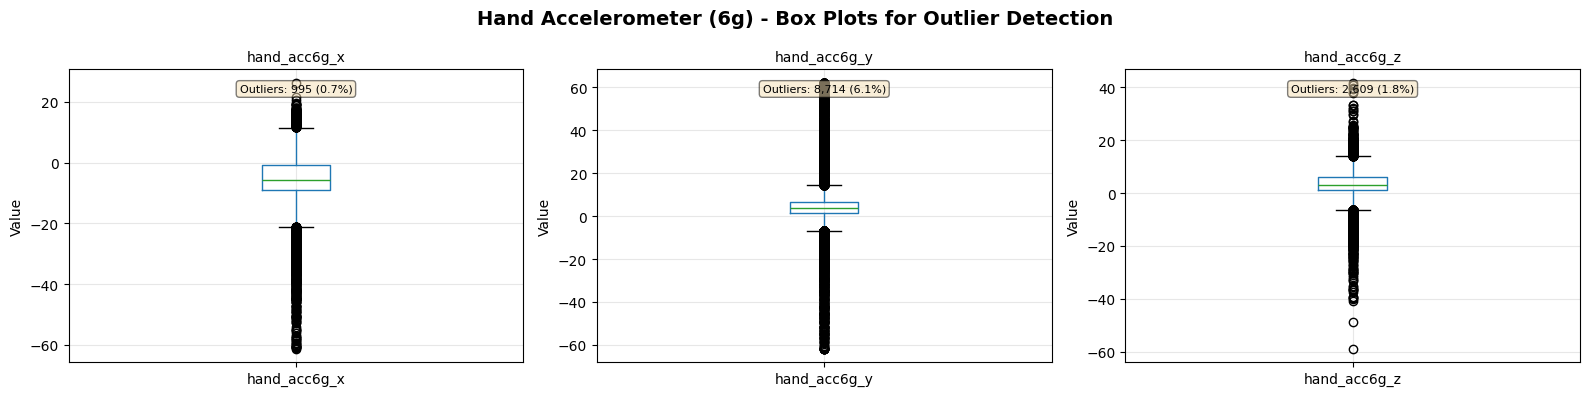

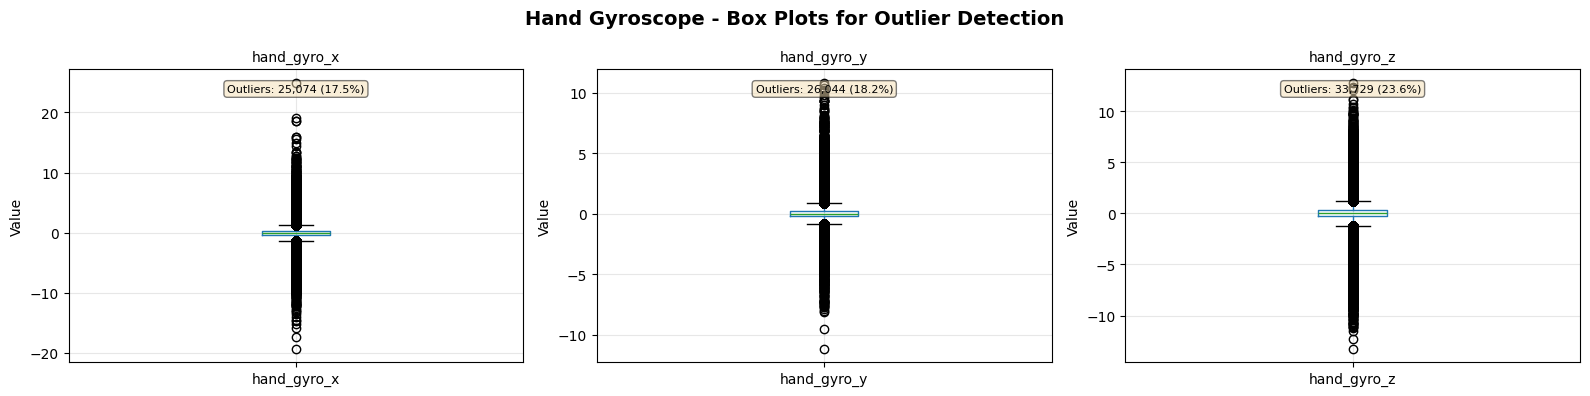

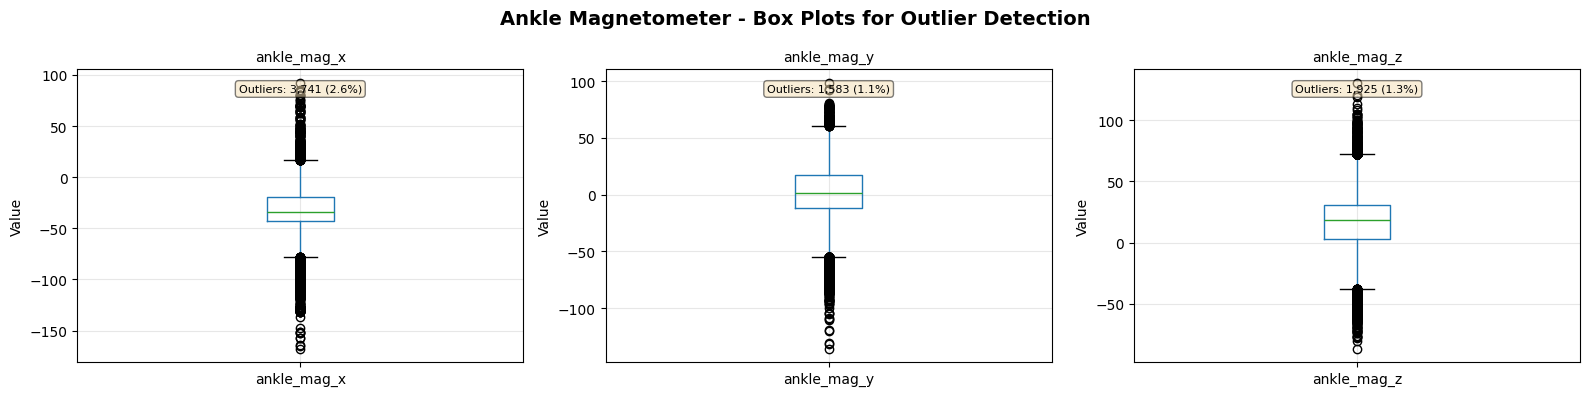

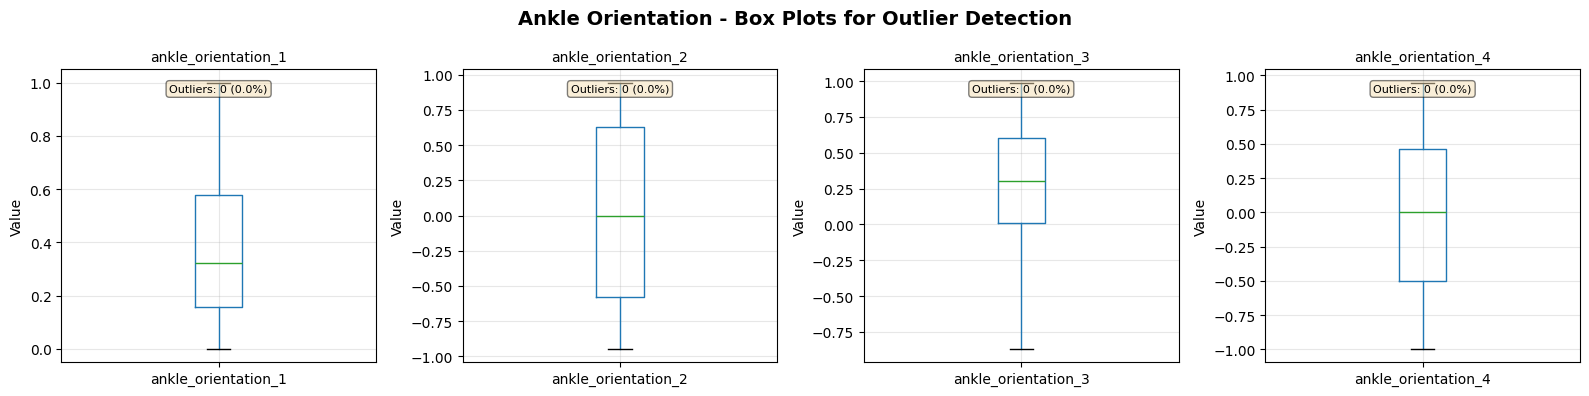



### OUTLIER SUMMARY & RECOMMENDATIONS ###

Total outlier data points across all features: 613,402
Average outlier percentage per feature: 8.25%

Features with >10% outliers: 15
       Feature  Outlier_Percent
ankle_acc16g_x        35.275076
 ankle_acc6g_x        35.050653
  ankle_gyro_z        32.615550
  ankle_gyro_x        30.641181
  ankle_gyro_y        28.023603
   hand_gyro_z        23.581271
   hand_gyro_y        18.208385
ankle_acc16g_y        18.047583
 ankle_acc6g_y        17.758839
  chest_gyro_y        17.625303
   hand_gyro_x        17.530220
chest_acc16g_y        16.097684
 chest_acc6g_y        15.962051
  chest_gyro_z        15.549558
  chest_gyro_x        15.486636

### RECOMMENDATIONS ###
1. Sensor data typically has natural outliers (rapid movements, sensor noise)
2. For this project, outliers are likely REAL physical activities, not errors
3. RECOMMENDATION: Keep outliers - they represent valid extreme movements
4. Machine learning models (Random Forest, SVM) are ro

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv('drive/MyDrive/ai/dataset.csv')

print("="*60)
print("TASK 1.4: DUPLICATES & OUTLIERS DETECTION")
print("="*60)

# ============================================
# PART 1: CHECK FOR DUPLICATES
# ============================================
print("\n### PART 1: DUPLICATE DETECTION ###\n")

# Check for complete duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Complete duplicate rows: {duplicate_rows:,}")

if duplicate_rows > 0:
    print(f"Percentage of duplicates: {(duplicate_rows/len(df))*100:.2f}%")
    print("\nSample of duplicate rows:")
    print(df[df.duplicated(keep=False)].head(10))
else:
    print("✓ No complete duplicate rows found")

# Check for duplicates excluding timestamp (same sensor readings at different times)
cols_without_timestamp = df.columns.drop('timestamp').tolist()
duplicate_sensors = df.duplicated(subset=cols_without_timestamp).sum()
print(f"\nDuplicate sensor readings (excluding timestamp): {duplicate_sensors:,}")

# Check duplicates by key columns
print("\n### Checking for duplicates by activity and subject ###")
duplicate_by_activity = df.duplicated(subset=['timestamp', 'subject_file', 'activity_name']).sum()
print(f"Duplicate timestamp-subject-activity combinations: {duplicate_by_activity:,}")

# ============================================
# PART 2: OUTLIER DETECTION USING BOX PLOTS
# ============================================
print("\n\n### PART 2: OUTLIER DETECTION ###\n")

# Select numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude IDs and timestamp
exclude_cols = ['activity_id', 'timestamp']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Analyzing {len(feature_cols)} numeric features for outliers\n")

# Define sensor groups for organized visualization
sensor_groups = {
    'Physiological': ['heart_rate', 'hand_temperature'],
    'Hand Accelerometer (16g)': [col for col in feature_cols if 'hand_acc16g' in col],
    'Hand Accelerometer (6g)': [col for col in feature_cols if 'hand_acc6g' in col],
    'Hand Gyroscope': [col for col in feature_cols if 'hand_gyro' in col],
    'Ankle Magnetometer': [col for col in feature_cols if 'ankle_mag' in col],
    'Ankle Orientation': [col for col in feature_cols if 'ankle_orientation' in col]
}

# Calculate outliers using IQR method for each feature
outlier_summary = []

for feature in feature_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_summary.append({
        'Feature': feature,
        'Outlier_Count': outlier_count,
        'Outlier_Percent': outlier_percent,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min': df[feature].min(),
        'Max': df[feature].max()
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('Outlier_Percent', ascending=False)

print("### TOP 10 FEATURES WITH MOST OUTLIERS ###")
print(outlier_df[['Feature', 'Outlier_Count', 'Outlier_Percent', 'Min', 'Max']].head(10).to_string(index=False))

# ============================================
# PART 3: VISUALIZE OUTLIERS WITH BOX PLOTS
# ============================================
print("\n\n### GENERATING BOX PLOTS FOR OUTLIER VISUALIZATION ###\n")

# Create box plots for each sensor group
for group_name, features in sensor_groups.items():
    if not features:
        continue

    n_features = len(features)
    if n_features == 0:
        continue

    # Create subplots
    fig, axes = plt.subplots(1, min(n_features, 4), figsize=(16, 4))
    fig.suptitle(f'{group_name} - Box Plots for Outlier Detection', fontsize=14, fontweight='bold')

    if n_features == 1:
        axes = [axes]

    for idx, feature in enumerate(features[:4]):  # Limit to 4 per row
        ax = axes[idx] if n_features > 1 else axes[0]

        # Create box plot
        df.boxplot(column=feature, ax=ax)
        ax.set_title(feature, fontsize=10)
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)

        # Add outlier count
        feature_outliers = outlier_df[outlier_df['Feature'] == feature]
        if not feature_outliers.empty:
            outlier_count = feature_outliers['Outlier_Count'].values[0]
            outlier_percent = feature_outliers['Outlier_Percent'].values[0]
            ax.text(0.5, 0.95, f'Outliers: {outlier_count:,} ({outlier_percent:.1f}%)',
                   transform=ax.transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=8)

    plt.tight_layout()
    plt.show()

    # If more than 4 features, create another plot
    if n_features > 4:
        remaining_features = features[4:8]
        fig, axes = plt.subplots(1, len(remaining_features), figsize=(16, 4))
        fig.suptitle(f'{group_name} (continued) - Box Plots', fontsize=14, fontweight='bold')

        if len(remaining_features) == 1:
            axes = [axes]

        for idx, feature in enumerate(remaining_features):
            ax = axes[idx] if len(remaining_features) > 1 else axes[0]
            df.boxplot(column=feature, ax=ax)
            ax.set_title(feature, fontsize=10)
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)

            feature_outliers = outlier_df[outlier_df['Feature'] == feature]
            if not feature_outliers.empty:
                outlier_count = feature_outliers['Outlier_Count'].values[0]
                outlier_percent = feature_outliers['Outlier_Percent'].values[0]
                ax.text(0.5, 0.95, f'Outliers: {outlier_count:,} ({outlier_percent:.1f}%)',
                       transform=ax.transAxes, ha='center', va='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                       fontsize=8)

        plt.tight_layout()
        plt.show()

# ============================================
# PART 4: SUMMARY & RECOMMENDATIONS
# ============================================
print("\n\n### OUTLIER SUMMARY & RECOMMENDATIONS ###\n")

total_outliers = outlier_df['Outlier_Count'].sum()
avg_outlier_percent = outlier_df['Outlier_Percent'].mean()

print(f"Total outlier data points across all features: {total_outliers:,}")
print(f"Average outlier percentage per feature: {avg_outlier_percent:.2f}%")

# Features with high outliers (>10%)
high_outlier_features = outlier_df[outlier_df['Outlier_Percent'] > 10]
print(f"\nFeatures with >10% outliers: {len(high_outlier_features)}")
if not high_outlier_features.empty:
    print(high_outlier_features[['Feature', 'Outlier_Percent']].to_string(index=False))

print("\n### RECOMMENDATIONS ###")
print("1. Sensor data typically has natural outliers (rapid movements, sensor noise)")
print("2. For this project, outliers are likely REAL physical activities, not errors")
print("3. RECOMMENDATION: Keep outliers - they represent valid extreme movements")
print("4. Machine learning models (Random Forest, SVM) are robust to outliers")
print("5. If needed, outlier handling can be done during feature scaling (RobustScaler)")

# ============================================
# PART 5: HANDLING DUPLICATES (IF ANY)
# ============================================
print("\n\n### HANDLING DUPLICATES ###\n")

if duplicate_rows > 0:
    print(f"Removing {duplicate_rows:,} duplicate rows...")
    df_no_duplicates = df.drop_duplicates()
    print(f"Dataset after removing duplicates: {len(df_no_duplicates):,} rows")

    # Save
    df_no_duplicates.to_csv('drive/MyDrive/ai/dataset_no_duplicates.csv', index=False)
    print("✓ Saved to: dataset_no_duplicates.csv")
else:
    print("✓ No duplicates to remove")
    print("✓ Current dataset is ready for modeling")

print("\n" + "="*60)
print("TASK 1.4 COMPLETED")
print("="*60)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle

# Load dataset
df = pd.read_csv('drive/MyDrive/ai/dataset.csv')

print("="*70)
print("TASK 1.5: ENCODE LABELS - Convert Activity Names to Numbers")
print("="*70)

# ============================================
# STEP 1: SHOW CURRENT STATE
# ============================================
print("\n### STEP 1: CURRENT ACTIVITY LABELS ###\n")

print("Current activities in dataset:")
print(f"  - Total unique activities: {df['activity_name'].nunique()}")
print(f"  - Data type: {df['activity_name'].dtype} (string/object)")
print(f"  - Total rows: {len(df):,}")

print("\nActivity distribution:")
activity_dist = df['activity_name'].value_counts().sort_values(ascending=False)
for activity, count in activity_dist.items():
    print(f"  {activity:20s} : {count:6,} rows ({count/len(df)*100:5.2f}%)")

# Show original activity_id vs activity_name
print("\n\nOriginal activity_id → activity_name mapping:")
original_mapping = df[['activity_id', 'activity_name']].drop_duplicates().sort_values('activity_id')
print(original_mapping.to_string(index=False))

# ============================================
# STEP 2: APPLY LABEL ENCODING
# ============================================
print("\n\n### STEP 2: APPLYING LABEL ENCODER ###\n")

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder to activity names and transform them
df['activity_encoded'] = label_encoder.fit_transform(df['activity_name'])

print("✓ LabelEncoder fitted and applied to 'activity_name' column")
print(f"✓ New column created: 'activity_encoded'")
print(f"✓ Encoded values data type: {df['activity_encoded'].dtype} (numeric)")

# ============================================
# STEP 3: SHOW ENCODING MAPPING
# ============================================
print("\n\n### STEP 3: ENCODING MAPPING ###\n")

# Create comprehensive mapping table
mapping_table = df[['activity_id', 'activity_name', 'activity_encoded']].drop_duplicates().sort_values('activity_encoded')

print("Complete Mapping Table:")
print("┌" + "─"*12 + "┬" + "─"*22 + "┬" + "─"*18 + "┐")
print("│ Original ID│ Activity Name        │ Encoded Value    │")
print("├" + "─"*12 + "┼" + "─"*22 + "┼" + "─"*18 + "┤")

for _, row in mapping_table.iterrows():
    print(f"│ {row['activity_id']:10d} │ {row['activity_name']:20s} │ {row['activity_encoded']:16d} │")

print("└" + "─"*12 + "┴" + "─"*22 + "┴" + "─"*18 + "┘")

# Show LabelEncoder classes (alphabetically sorted - how LabelEncoder assigns numbers)
print("\n\nHow LabelEncoder assigns numbers (alphabetically):")
for idx, activity in enumerate(label_encoder.classes_):
    print(f"  {idx:2d} ← '{activity}'")

# ============================================
# STEP 4: CREATE TARGET VARIABLE (y)
# ============================================
print("\n\n### STEP 4: CREATE NUMERIC TARGET VARIABLE (y) ###\n")

# Extract target variable
y = df['activity_encoded'].copy()

print(f"Target variable (y) created:")
print(f"  - Shape: {y.shape}")
print(f"  - Data type: {y.dtype}")
print(f"  - Range: {y.min()} to {y.max()}")
print(f"  - Unique values: {sorted(y.unique())}")

# Show distribution of encoded values
print("\n\nEncoded target distribution:")
encoded_dist = y.value_counts().sort_index()
for encoded_val, count in encoded_dist.items():
    activity = label_encoder.inverse_transform([encoded_val])[0]
    print(f"  {encoded_val:2d} ({activity:20s}) : {count:6,} samples")

# ============================================
# STEP 5: VERIFICATION
# ============================================
print("\n\n### STEP 5: VERIFICATION ###\n")

# Verify encoding is correct
print("Verification checks:")
check1 = df['activity_name'].nunique() == df['activity_encoded'].nunique()
print(f"  ✓ All activities encoded: {check1}")

check2 = df['activity_encoded'].isnull().sum() == 0
print(f"  ✓ No missing values in encoded column: {check2}")

check3 = df['activity_encoded'].min() >= 0
print(f"  ✓ Encoded values are non-negative: {check3}")

check4 = set(df['activity_encoded'].unique()) == set(range(df['activity_name'].nunique()))
print(f"  ✓ Encoded values are sequential (0 to n-1): {check4}")

# Sample verification - show some examples
print("\n\nSample rows showing encoding:")
sample_df = df[['activity_id', 'activity_name', 'activity_encoded']].sample(15, random_state=42).sort_values('activity_encoded')
print(sample_df.to_string(index=False))

# ============================================
# STEP 6: SAVE RESULTS
# ============================================
print("\n\n### STEP 6: SAVING RESULTS ###\n")

# Save the dataset with encoded labels
output_path = 'drive/MyDrive/ai/dataset_encoded.csv'
df.to_csv(output_path, index=False)
print(f"✓ Dataset with encoded labels saved to: {output_path}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)} (including 'activity_encoded')")

# Save just the mapping for reference
mapping_path = 'drive/MyDrive/ai/activity_encoding_mapping.csv'
mapping_table.to_csv(mapping_path, index=False)
print(f"✓ Encoding mapping saved to: {mapping_path}")


print("\n" + "="*70)
print("TASK 1.5 COMPLETED SUCCESSFULLY!")

TASK 1.5: ENCODE LABELS - Convert Activity Names to Numbers

### STEP 1: CURRENT ACTIVITY LABELS ###

Current activities in dataset:
  - Total unique activities: 13
  - Data type: object (string/object)
  - Total rows: 143,033

Activity distribution:
  other                : 46,341 rows (32.40%)
  ironing              : 11,910 rows ( 8.33%)
  walking              : 11,838 rows ( 8.28%)
  lying                :  9,624 rows ( 6.73%)
  standing             :  9,463 rows ( 6.62%)
  Nordic_walking       :  9,316 rows ( 6.51%)
  sitting              :  9,233 rows ( 6.46%)
  vacuum_cleaning      :  8,758 rows ( 6.12%)
  cycling              :  8,165 rows ( 5.71%)
  ascending_stairs     :  5,857 rows ( 4.09%)
  descending_stairs    :  5,245 rows ( 3.67%)
  running              :  4,858 rows ( 3.40%)
  rope_jumping         :  2,425 rows ( 1.70%)


Original activity_id → activity_name mapping:
 activity_id     activity_name
           0             other
           1             lying
          

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

# Load encoded dataset
df = pd.read_csv('drive/MyDrive/ai/dataset_encoded.csv')

print("="*60)
print("TASK 1.6: FEATURE SCALING")
print("="*60)

# Identify feature columns (exclude non-feature columns)
exclude_cols = ['activity_id', 'activity_name', 'activity_encoded', 'subject_file', 'timestamp']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal features to scale: {len(feature_cols)}")
print(f"Features: {feature_cols[:5]}... (showing first 5)")

# Extract features
X = df[feature_cols]

print(f"\nBefore scaling:")
print(f"  Shape: {X.shape}")
print(f"\nSample statistics (first 5 features):")
print(X[feature_cols[:5]].describe())

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

print(f"\nAfter scaling:")
print(f"  Shape: {X_scaled_df.shape}")
print(f"\nSample statistics (first 5 features):")
print(X_scaled_df[feature_cols[:5]].describe())

# Create complete scaled dataset
df_scaled = df[exclude_cols].copy()
df_scaled = pd.concat([df_scaled, X_scaled_df], axis=1)

# Save scaler
scaler_path = 'drive/MyDrive/ai/standard_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n✓ StandardScaler saved: {scaler_path}")

# Save scaled dataset
output_path = 'drive/MyDrive/ai/dataset_scaled.csv'
df_scaled.to_csv(output_path, index=False)
print(f"✓ Scaled dataset saved: {output_path}")
print(f"  Rows: {len(df_scaled):,}")
print(f"  Columns: {len(df_scaled.columns)}")

print("\n" + "="*60)
print("TASK 1.6 COMPLETED")
print("="*60)

TASK 1.6: FEATURE SCALING

Total features to scale: 52
Features: ['heart_rate', 'hand_temperature', 'hand_acc16g_x', 'hand_acc16g_y', 'hand_acc16g_z']... (showing first 5)

Before scaling:
  Shape: (143033, 52)

Sample statistics (first 5 features):
          heart_rate  hand_temperature  hand_acc16g_x  hand_acc16g_y  \
count  143033.000000     143033.000000  142374.000000  142374.000000   
mean      109.693898         32.655817      -4.956950       3.593843   
std         7.770443          1.838777       5.982182       6.305613   
min        57.000000         24.750000     -87.516200     -71.233600   
25%       109.699408         31.437500      -9.018435       1.287075   
50%       109.699408         33.125000      -5.764990       3.587150   
75%       109.699408         34.000000      -0.786515       6.606653   
max       202.000000         35.500000      31.054400     145.983000   

       hand_acc16g_z  
count  142374.000000  
mean        3.168528  
std         3.842082  
min      

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

df_scaled = pd.read_csv('drive/MyDrive/ai/dataset_scaled.csv')
y = df_scaled['activity_encoded']
X_scaled_df = df_scaled.drop(columns=['activity_id', 'activity_name', 'activity_encoded', 'subject_file', 'timestamp'])

print("="*60)
print("TASK 1.7: TRAIN-TEST SPLIT (80-20)")
print("="*60)

# Perform 80-20 train-test split, stratified by 'activity_encoded'
# X_scaled_df contains the scaled features
# y contains the encoded activity labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test:  {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test:  {y_test.shape}")

print("\nTrain/Test split distribution (y_train):")
print(y_train.value_counts(normalize=True).sort_index())

print("\nTrain/Test split distribution (y_test):")
print(y_test.value_counts(normalize=True).sort_index())

print("\nVerification of stratification (should be very similar):")
print(pd.DataFrame({
    'Original': y.value_counts(normalize=True),
    'Train': y_train.value_counts(normalize=True),
    'Test': y_test.value_counts(normalize=True)
}).sort_index())


print("\n" + "="*60)
print("TASK 1.7 COMPLETED")
print("="*60)

TASK 1.7: TRAIN-TEST SPLIT (80-20)

Shape of X_train: (114426, 52)
Shape of X_test:  (28607, 52)
Shape of y_train: (114426,)
Shape of y_test:  (28607,)

Train/Test split distribution (y_train):
activity_encoded
0     0.065134
1     0.040952
2     0.057085
3     0.036670
4     0.083268
5     0.067284
6     0.323991
7     0.016954
8     0.033970
9     0.064548
10    0.066156
11    0.061227
12    0.082761
Name: proportion, dtype: float64

Train/Test split distribution (y_test):
activity_encoded
0     0.065124
1     0.040934
2     0.057084
3     0.036669
4     0.083266
5     0.067291
6     0.323977
7     0.016954
8     0.033943
9     0.064565
10    0.066173
11    0.061244
12    0.082777
Name: proportion, dtype: float64

Verification of stratification (should be very similar):
                  Original     Train      Test
activity_encoded                              
0                 0.065132  0.065134  0.065124
1                 0.040949  0.040952  0.040934
2                 0.057085  0

TASK 1.8: VISUALIZATIONS - CLASS DISTRIBUTION


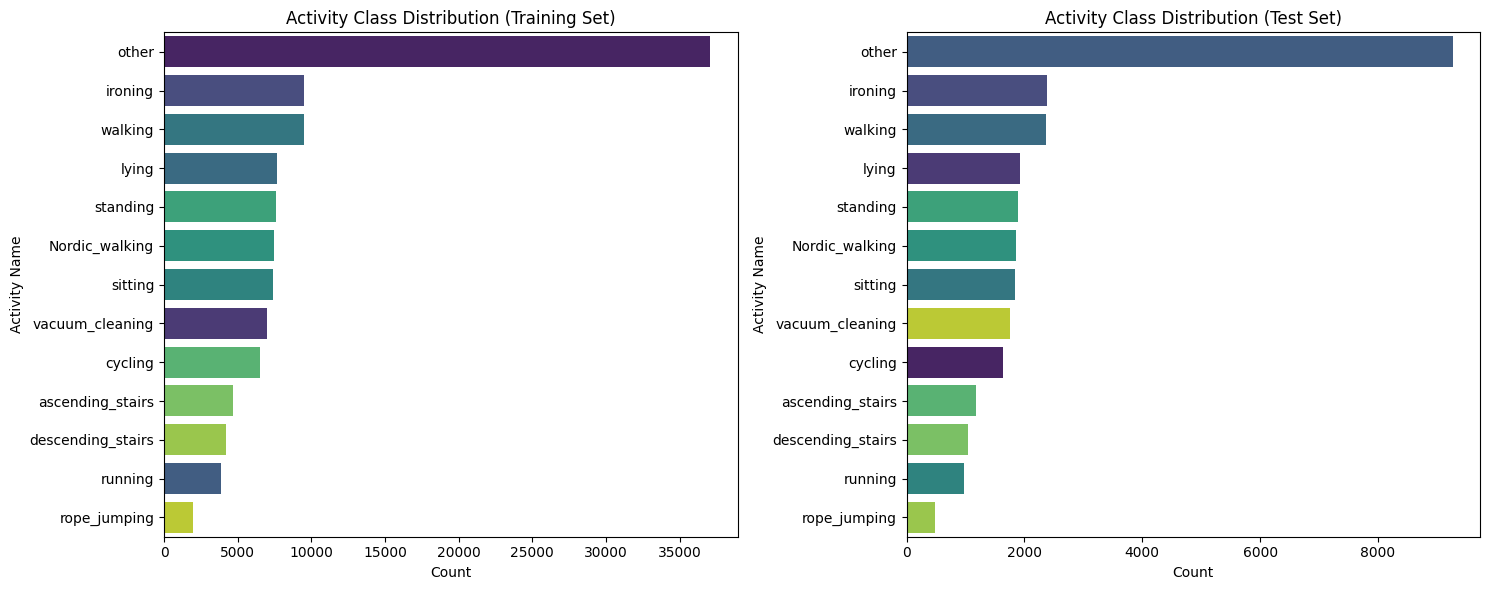

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*60)
print("TASK 1.8: VISUALIZATIONS - CLASS DISTRIBUTION")
print("="*60)

# Map encoded labels back to activity names for plotting
y_train_names = y_train.map(lambda x: label_encoder.inverse_transform([x])[0])
y_test_names = y_test.map(lambda x: label_encoder.inverse_transform([x])[0])

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(y=y_train_names, order=y_train_names.value_counts().index, palette='viridis', hue=y_train_names, legend=False)
plt.title('Activity Class Distribution (Training Set)')
plt.xlabel('Count')
plt.ylabel('Activity Name')

plt.subplot(1, 2, 2)
sns.countplot(y=y_test_names, order=y_test_names.value_counts().index, palette='viridis', hue=y_test_names, legend=False)
plt.title('Activity Class Distribution (Test Set)')
plt.xlabel('Count')
plt.ylabel('Activity Name')

plt.tight_layout()
plt.show()

TASK 1.9: VISUALIZATIONS - CORRELATION HEATMAP


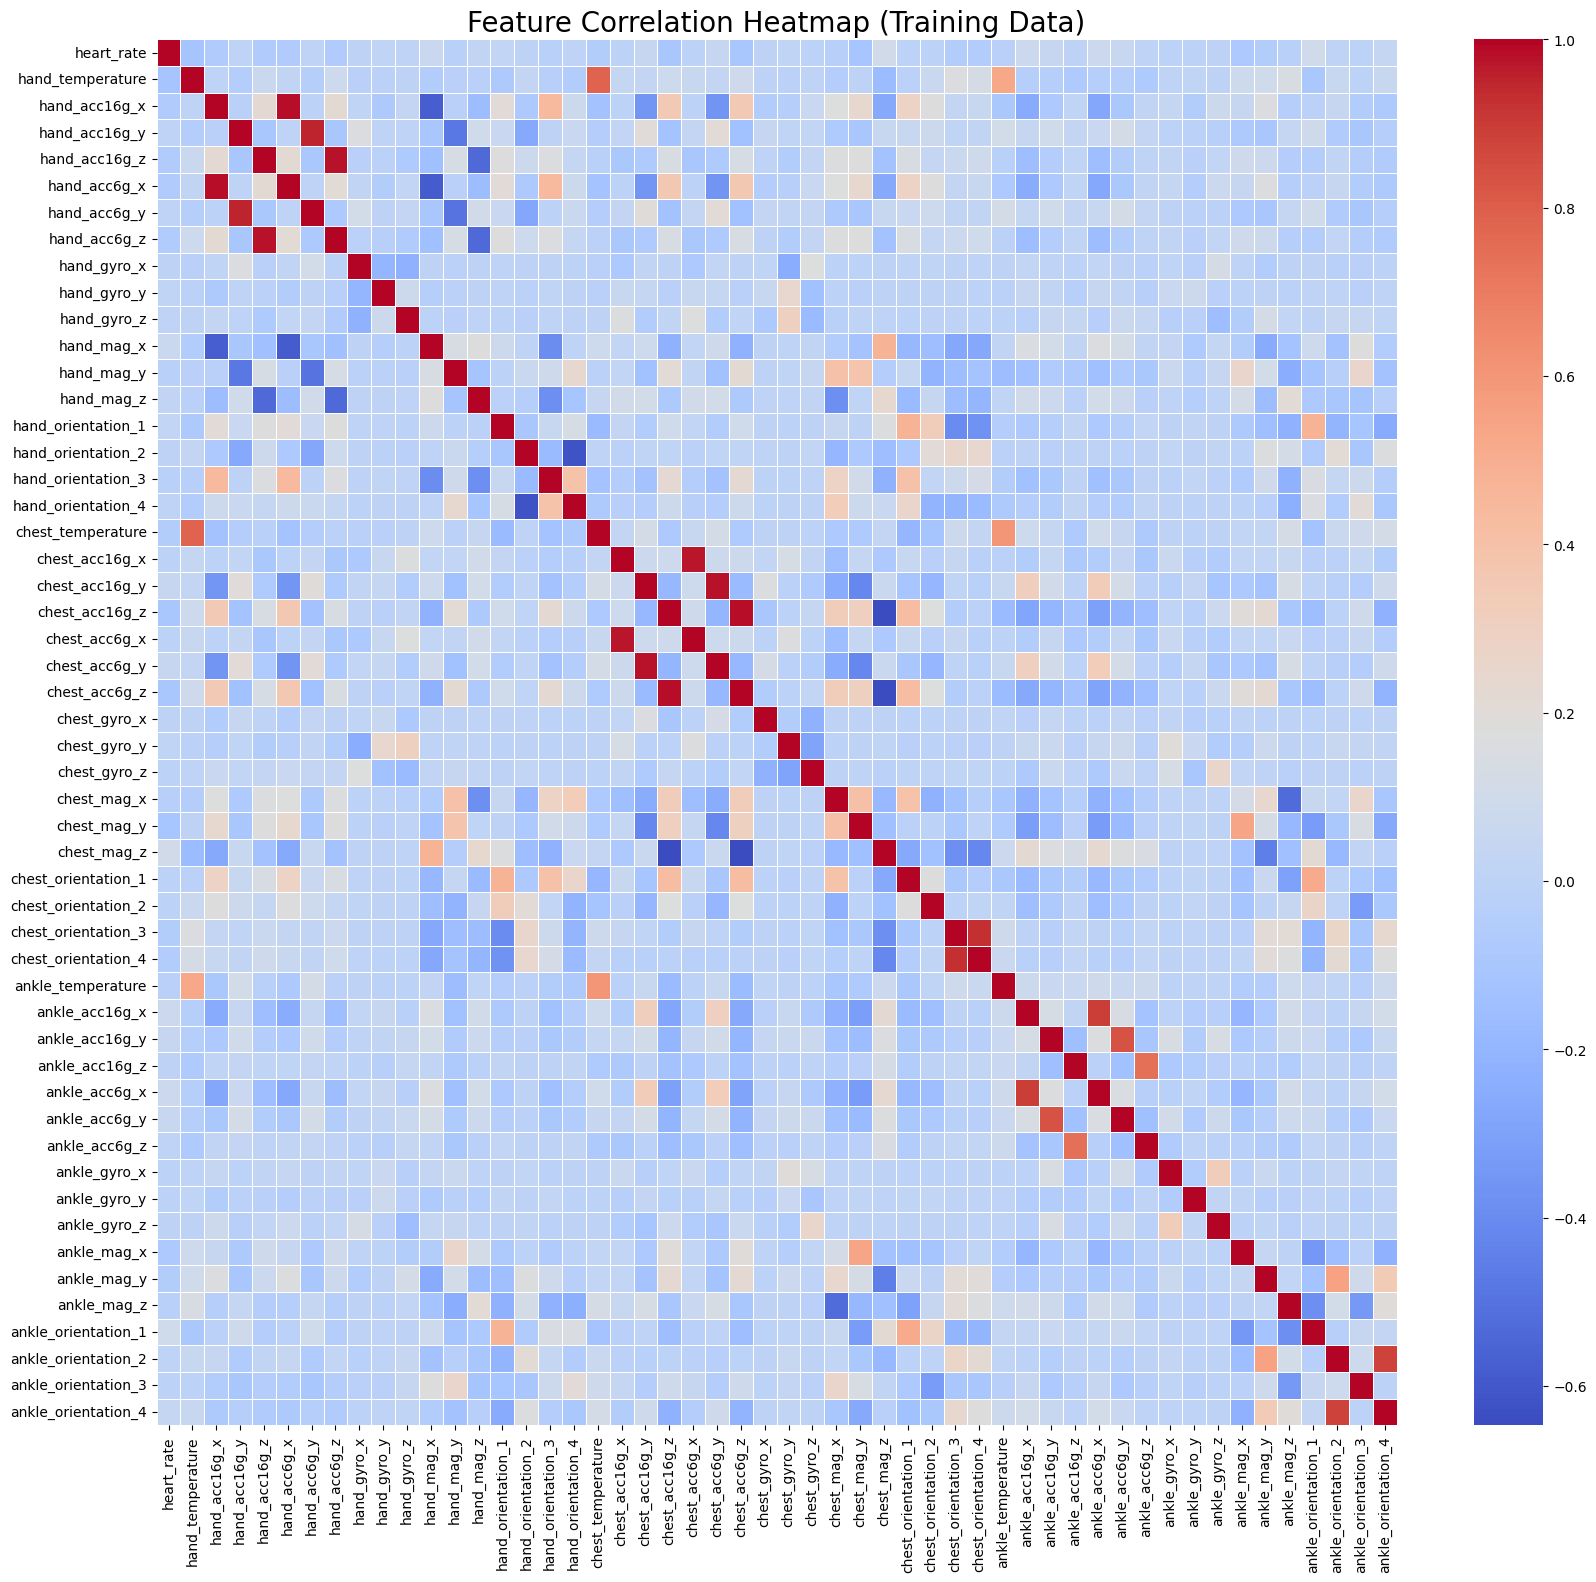

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*60)
print("TASK 1.9: VISUALIZATIONS - CORRELATION HEATMAP")
print("="*60)

plt.figure(figsize=(20, 18))
sns.heatmap(X_train.corr(), cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Feature Correlation Heatmap (Training Data)', fontsize=20)
plt.show()

TASK 1.10: VISUALIZATION - MISSING DATA HEATMAP


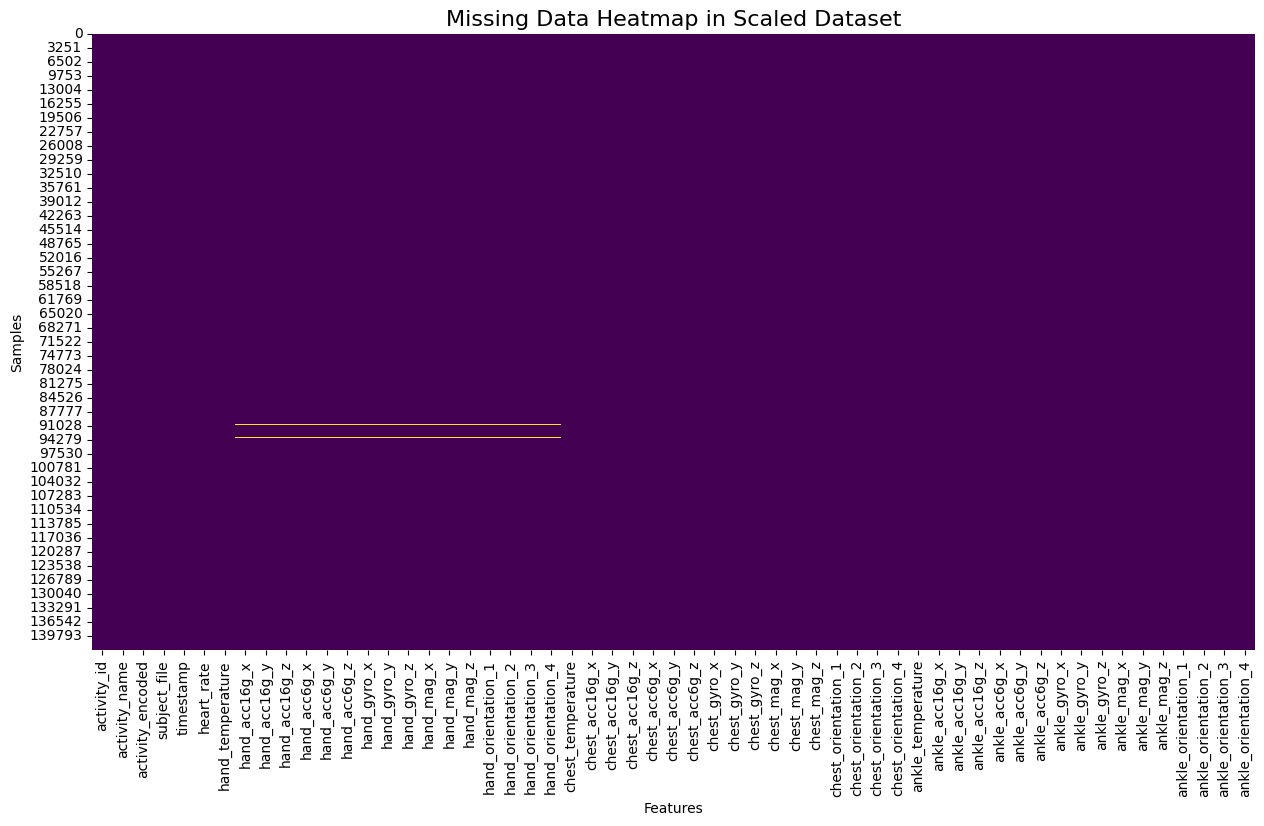


--- Missing Data Heatmap Generated ---

Columns with missing values and their counts:
hand_acc16g_x          659
hand_acc16g_y          659
hand_acc16g_z          659
hand_acc6g_x           659
hand_acc6g_y           659
hand_acc6g_z           659
hand_gyro_x            659
hand_gyro_y            659
hand_gyro_z            659
hand_mag_x             659
hand_mag_y             659
hand_mag_z             659
hand_orientation_1     659
hand_orientation_2     659
hand_orientation_3     659
hand_orientation_4     659
chest_temperature      180
chest_acc16g_x         180
chest_acc16g_y         180
chest_acc16g_z         180
chest_acc6g_x          180
chest_acc6g_y          180
chest_acc6g_z          180
chest_gyro_x           180
chest_gyro_y           180
chest_gyro_z           180
chest_mag_x            180
chest_mag_y            180
chest_mag_z            180
chest_orientation_1    180
chest_orientation_2    180
chest_orientation_3    180
chest_orientation_4    180
dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("="*60)
print("TASK 1.10: VISUALIZATION - MISSING DATA HEATMAP")
print("="*60)

plt.figure(figsize=(15, 8))
sns.heatmap(df_scaled.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap in Scaled Dataset', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

print("\n--- Missing Data Heatmap Generated ---")

missing_counts = df_scaled.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]

if not missing_cols.empty:
    print("\nColumns with missing values and their counts:")
    print(missing_cols.sort_values(ascending=False))
else:
    print("\n✓ No missing values found in the scaled dataset.")

# Supervised Learning

In [ ]:
# Imports & Data Prep
# ===== Setup =====
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Make plots a bit nicer
sns.set(style="whitegrid", font_scale=1.0)

# ===== Load scaled dataset =====
df = pd.read_csv('drive/MyDrive/ai/dataset_scaled.csv')

df.head()
df.info()

# Columns to drop from features
drop_cols = ["activity_id", "activity_name", "activity_encoded", "subject_file", "timestamp"]

X = df.drop(columns=drop_cols)
y = df["activity_encoded"]   # numeric activity label

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique activities:", y.nunique())

# ======== split and test ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ====== Helper function for all models =======
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted", zero_division=0
    )

    print(f"=== {name} ===")
    print("Accuracy :", acc)
    print("Precision:", precision)
    print("Recall   :", recall)
    print("F1-score :", f1)
    print()

    return {
        "model": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "y_pred": y_pred,
        "estimator": model
    }


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143033 entries, 0 to 143032
Data columns (total 57 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   activity_id          143033 non-null  int64  
 1   activity_name        143033 non-null  object 
 2   activity_encoded     143033 non-null  int64  
 3   subject_file         143033 non-null  object 
 4   timestamp            143033 non-null  float64
 5   heart_rate           143033 non-null  float64
 6   hand_temperature     143033 non-null  float64
 7   hand_acc16g_x        142374 non-null  float64
 8   hand_acc16g_y        142374 non-null  float64
 9   hand_acc16g_z        142374 non-null  float64
 10  hand_acc6g_x         142374 non-null  float64
 11  hand_acc6g_y         142374 non-null  float64
 12  hand_acc6g_z         142374 non-null  float64
 13  hand_gyro_x          142374 non-null  float64
 14  hand_gyro_y          142374 non-null  float64
 15  hand_gyro_z      

In [ ]:
# ========= Create X, y and Impute Missing Values =============
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# ----- 1. Choose features and label -----
drop_cols = ["activity_id", "activity_name", "activity_encoded", "subject_file", "timestamp"]

X = df.drop(columns=drop_cols)
y = df["activity_encoded"]

print("NaNs before imputation:", X.isna().sum().sum())   # just to check

# ----- 2. Impute missing values (median for numeric data) -----
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)   # returns a numpy array

# (optional) put back into a DataFrame so shapes are nicer to inspect
X = pd.DataFrame(X_imputed, columns=X.columns)

print("NaNs after imputation:", X.isna().sum().sum())    # should be 0

# ----- 3. Train / test split -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


NaNs before imputation: 13604
NaNs after imputation: 0
X_train shape: (114426, 52)
X_test shape: (28607, 52)


In [ ]:
# ========== Logistic Regression =======
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred_lr = log_reg.predict(X_test)

# Evaluate
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr, rec_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test, y_pred_lr, average="weighted", zero_division=0
)

print("=== Logistic Regression Metrics ===")
print(f"Accuracy : {acc_lr:.4f}")
print(f"Precision (weighted): {prec_lr:.4f}")
print(f"Recall    (weighted): {rec_lr:.4f}")
print(f"F1-score  (weighted): {f1_lr:.4f}")

print("\nDetailed per-class report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression Metrics ===
Accuracy : 0.6679
Precision (weighted): 0.6695
Recall    (weighted): 0.6679
F1-score  (weighted): 0.6573

Detailed per-class report:
              precision    recall  f1-score   support

           0       0.61      0.32      0.42      1863
           1       0.58      0.33      0.42      1171
           2       0.86      0.88      0.87      1633
           3       0.51      0.23      0.31      1049
           4       0.76      0.82      0.79      2382
           5       0.96      0.93      0.94      1925
           6       0.57      0.72      0.64      9268
           7       0.62      0.41      0.49       485
           8       0.68      0.41      0.51       971
           9       0.78      0.77      0.78      1847
          10       0.65      0.75      0.70      1893
          11       0.73      0.64      0.68      1752
          12       0.63      0.60      0.62      2368

    accuracy                           0.67     28607
   macro avg       

In [ ]:
# ==== random Forest =====
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

rf = RandomForestClassifier(
    n_estimators=80,      # fewer trees = faster
    max_depth=20,         # limit depth to avoid huge trees
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",  # try subset of features at each split
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average="weighted", zero_division=0
)

print("=== Random Forest Metrics ===")
print(f"Accuracy : {acc_rf:.4f}")
print(f"Precision (weighted): {prec_rf:.4f}")
print(f"Recall    (weighted): {rec_rf:.4f}")
print(f"F1-score  (weighted): {f1_rf:.4f}")

print("\nDetailed per-class report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))


=== Random Forest Metrics ===
Accuracy : 0.9445
Precision (weighted): 0.9487
Recall    (weighted): 0.9445
F1-score  (weighted): 0.9439

Detailed per-class report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1863
           1       0.96      0.74      0.83      1171
           2       0.99      0.96      0.98      1633
           3       0.96      0.72      0.82      1049
           4       0.98      0.99      0.98      2382
           5       1.00      0.95      0.97      1925
           6       0.87      0.98      0.92      9268
           7       1.00      0.87      0.93       485
           8       0.99      0.94      0.97       971
           9       1.00      0.97      0.99      1847
          10       0.99      0.97      0.98      1893
          11       0.98      0.88      0.93      1752
          12       0.98      0.94      0.96      2368

    accuracy                           0.94     28607
   macro avg       0.98  

In [ ]:
# ======== SVM (Linear) =======
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import time

start = time.time()

svm_linear = LinearSVC(
    C=1.0,
    max_iter=5000,
    dual=False  # usually faster when n_samples > n_features
)

svm_linear.fit(X_train, y_train)
y_pred_svm_lin = svm_linear.predict(X_test)

acc_svm_lin = accuracy_score(y_test, y_pred_svm_lin)
prec_svm_lin, rec_svm_lin, f1_svm_lin, _ = precision_recall_fscore_support(
    y_test, y_pred_svm_lin, average="weighted", zero_division=0
)

print("=== SVM (Linear) Metrics ===")
print(f"Time (sec): {time.time() - start:.1f}")
print(f"Accuracy : {acc_svm_lin:.4f}")
print(f"Precision (weighted): {prec_svm_lin:.4f}")
print(f"Recall    (weighted): {rec_svm_lin:.4f}")
print(f"F1-score  (weighted): {f1_svm_lin:.4f}")

print("\nDetailed per-class report:")
print(classification_report(y_test, y_pred_svm_lin, zero_division=0))


=== SVM (Linear) Metrics ===
Time (sec): 38.2
Accuracy : 0.6305
Precision (weighted): 0.6451
Recall    (weighted): 0.6305
F1-score  (weighted): 0.6004

Detailed per-class report:
              precision    recall  f1-score   support

           0       0.60      0.08      0.15      1863
           1       0.62      0.17      0.26      1171
           2       0.83      0.89      0.86      1633
           3       0.64      0.11      0.19      1049
           4       0.69      0.85      0.76      2382
           5       0.99      0.93      0.96      1925
           6       0.53      0.76      0.62      9268
           7       0.74      0.25      0.37       485
           8       0.71      0.29      0.41       971
           9       0.72      0.74      0.73      1847
          10       0.60      0.61      0.61      1893
          11       0.69      0.62      0.65      1752
          12       0.58      0.55      0.57      2368

    accuracy                           0.63     28607
   macro 

In [ ]:
# ===== RBF SVM on a subset (better accuracy, show trade-off) ====
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
import time

# ---- Create a smaller, stratified training subset (e.g., 30k samples) ----
sss = StratifiedShuffleSplit(n_splits=1, train_size=30000, random_state=42)
for small_idx, _ in sss.split(X_train, y_train):
    X_train_small = X_train.iloc[small_idx]
    y_train_small = y_train.iloc[small_idx]

print("Small train shape:", X_train_small.shape)

# ---- RBF SVM ----
svm_rbf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale"
)

start = time.time()

svm_rbf.fit(X_train_small, y_train_small)
y_pred_svm_rbf = svm_rbf.predict(X_test)   # still test on full test set

acc_svm_rbf = accuracy_score(y_test, y_pred_svm_rbf)
prec_svm_rbf, rec_svm_rbf, f1_svm_rbf, _ = precision_recall_fscore_support(
    y_test, y_pred_svm_rbf, average="weighted", zero_division=0
)

print("=== SVM (RBF, subset) Metrics ===")
print(f"Time (sec): {time.time() - start:.1f}")
print(f"Accuracy : {acc_svm_rbf:.4f}")
print(f"Precision (weighted): {prec_svm_rbf:.4f}")
print(f"Recall    (weighted): {rec_svm_rbf:.4f}")
print(f"F1-score  (weighted): {f1_svm_rbf:.4f}")

print("\nDetailed per-class report:")
print(classification_report(y_test, y_pred_svm_rbf, zero_division=0))


Small train shape: (30000, 52)
=== SVM (RBF, subset) Metrics ===
Time (sec): 86.4
Accuracy : 0.8807
Precision (weighted): 0.8847
Recall    (weighted): 0.8807
F1-score  (weighted): 0.8786

Detailed per-class report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1863
           1       0.80      0.63      0.70      1171
           2       0.98      0.92      0.95      1633
           3       0.82      0.47      0.60      1049
           4       0.94      0.95      0.94      2382
           5       1.00      0.93      0.97      1925
           6       0.80      0.91      0.85      9268
           7       0.99      0.75      0.85       485
           8       0.88      0.92      0.90       971
           9       0.99      0.95      0.97      1847
          10       0.90      0.95      0.92      1893
          11       0.93      0.81      0.87      1752
          12       0.88      0.88      0.88      2368

    accuracy               

In [ ]:
# ========= KNN Classifier ===========
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import time

# ---- Make a smaller stratified training set for KNN (e.g., 30k samples) ----
sss_knn = StratifiedShuffleSplit(n_splits=1, train_size=30000, random_state=42)
for idx_knn, _ in sss_knn.split(X_train, y_train):
    X_train_knn = X_train.iloc[idx_knn]
    y_train_knn = y_train.iloc[idx_knn]

print("KNN train subset shape:", X_train_knn.shape)

# ---- Define and train KNN ----
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance",
    metric="euclidean",
    n_jobs=-1
)

start = time.time()
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test)
elapsed = time.time() - start

# ---- Metrics ----
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn, rec_knn, f1_knn, _ = precision_recall_fscore_support(
    y_test, y_pred_knn, average="weighted", zero_division=0
)

print("=== KNN Metrics ===")
print(f"Time (sec): {elapsed:.1f}")
print(f"Accuracy : {acc_knn:.4f}")
print(f"Precision (weighted): {prec_knn:.4f}")
print(f"Recall    (weighted): {rec_knn:.4f}")
print(f"F1-score  (weighted): {f1_knn:.4f}")

print("\nDetailed per-class report:")
print(classification_report(y_test, y_pred_knn, zero_division=0))


KNN train subset shape: (30000, 52)
=== KNN Metrics ===
Time (sec): 8.5
Accuracy : 0.8619
Precision (weighted): 0.8654
Recall    (weighted): 0.8619
F1-score  (weighted): 0.8596

Detailed per-class report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1863
           1       0.75      0.63      0.69      1171
           2       0.96      0.96      0.96      1633
           3       0.80      0.45      0.58      1049
           4       0.90      0.95      0.92      2382
           5       0.99      0.95      0.97      1925
           6       0.83      0.85      0.84      9268
           7       0.95      0.77      0.85       485
           8       0.97      0.93      0.95       971
           9       0.96      0.97      0.96      1847
          10       0.88      0.97      0.92      1893
          11       0.92      0.75      0.83      1752
          12       0.70      0.90      0.79      2368

    accuracy                         

In [ ]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()


(np.int64(0), np.int64(0))

In [ ]:
# ====== Neural Network (MLPClassifier) =====
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import time

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=0.001,
    max_iter=50,          # keep it reasonable
    early_stopping=True,
    random_state=42,
    verbose=False
)

start = time.time()
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
elapsed = time.time() - start

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp, rec_mlp, f1_mlp, _ = precision_recall_fscore_support(
    y_test, y_pred_mlp, average="weighted", zero_division=0
)

print("=== Neural Network (MLP) Metrics ===")
print(f"Time (sec): {elapsed:.1f}")
print(f"Accuracy : {acc_mlp:.4f}")
print(f"Precision (weighted): {prec_mlp:.4f}")
print(f"Recall    (weighted): {rec_mlp:.4f}")
print(f"F1-score  (weighted): {f1_mlp:.4f}")

print("\nDetailed per-class report:")
print(classification_report(y_test, y_pred_mlp, zero_division=0))


=== Neural Network (MLP) Metrics ===
Time (sec): 130.2
Accuracy : 0.9281
Precision (weighted): 0.9283
Recall    (weighted): 0.9281
F1-score  (weighted): 0.9279

Detailed per-class report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1863
           1       0.80      0.77      0.78      1171
           2       0.98      0.97      0.97      1633
           3       0.82      0.74      0.78      1049
           4       0.97      0.97      0.97      2382
           5       0.99      0.96      0.97      1925
           6       0.89      0.93      0.91      9268
           7       0.93      0.93      0.93       485
           8       0.97      0.92      0.94       971
           9       0.99      0.98      0.98      1847
          10       0.97      0.97      0.97      1893
          11       0.95      0.90      0.92      1752
          12       0.91      0.94      0.93      2368

    accuracy                           0.93     28607


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model_name, y_true, y_pred, normalize=True):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm,
                annot=False,
                cmap="Blues",
                fmt=".2f" if normalize else "d")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


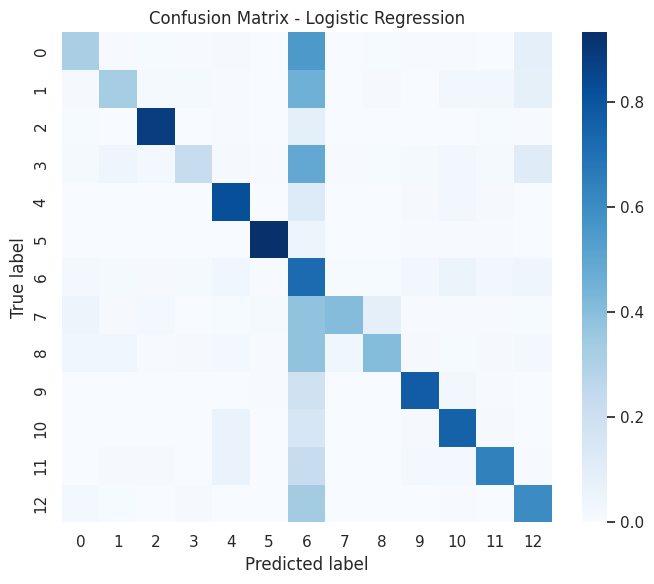

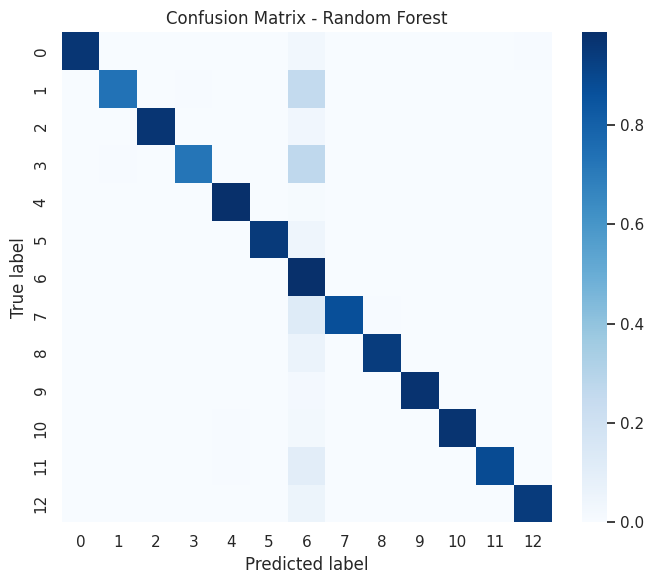

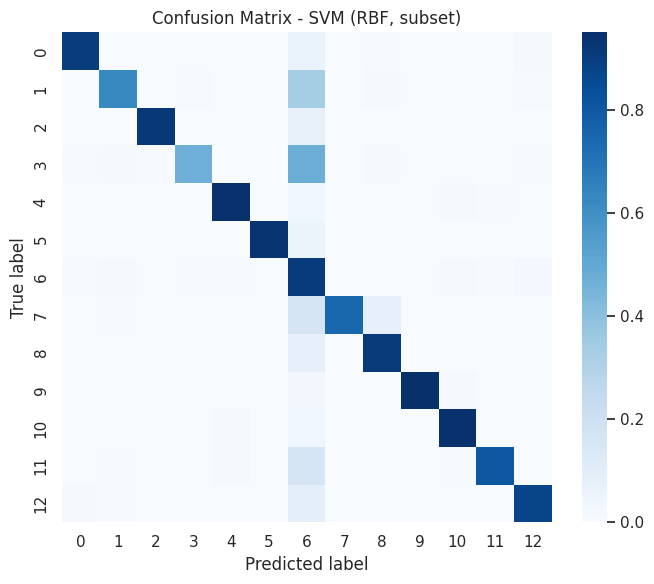

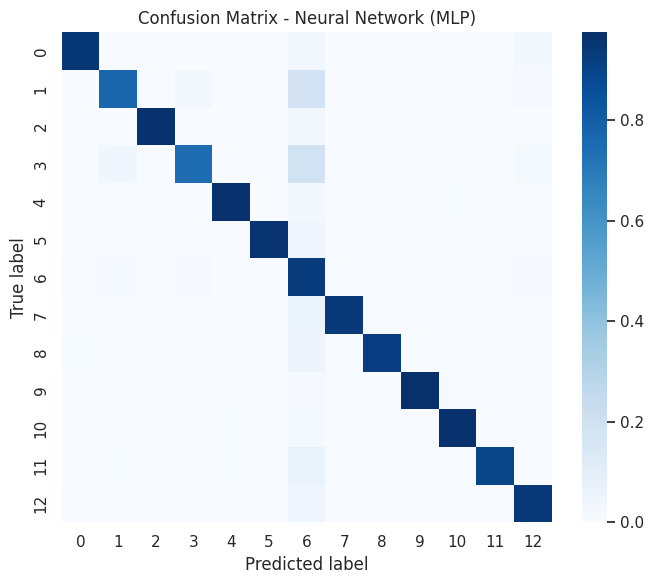

In [ ]:
# 1) Logistic Regression
plot_confusion_matrix("Logistic Regression", y_test, y_pred_lr)

# 2) Random Forest
plot_confusion_matrix("Random Forest", y_test, y_pred_rf)

# 3) SVM (RBF)
plot_confusion_matrix("SVM (RBF, subset)", y_test, y_pred_svm_rbf)

# 4) Neural Network (MLP)
plot_confusion_matrix("Neural Network (MLP)", y_test, y_pred_mlp)


In [ ]:
import pandas as pd

# --- Fill in the metrics from your results ---
metrics = {
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "SVM (Linear)",
        "SVM (RBF, subset)",
        "KNN (subset)",
        "Neural Network (MLP)"
    ],
    "Accuracy": [
        0.6679,   # logistic
        0.9445,   # random forest
        0.6305,   # linear SVM
        0.8807,   # rbf SVM (subset)
        0.8619,   # KNN
        0.9281    # MLP
    ],
    "Precision (weighted)": [
        0.6695,
        0.9487,
        0.6451,
        0.8847,
        0.8654,
        0.9283
    ],
    "Recall (weighted)": [
        0.6679,
        0.9445,
        0.6305,
        0.8807,
        0.8619,
        0.9281
    ],
    "F1-score (weighted)": [
        0.6573,
        0.9439,
        0.6004,
        0.8786,
        0.8596,
        0.9279
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df


,Model,Accuracy,Precision (weighted),Recall (weighted),F1-score (weighted)
0,Logistic Regression,0.6679,0.6695,0.6679,0.6573
1,Random Forest,0.9445,0.9487,0.9445,0.9439
2,SVM (Linear),0.6305,0.6451,0.6305,0.6004
3,"SVM (RBF, subset)",0.8807,0.8847,0.8807,0.8786
4,KNN (subset),0.8619,0.8654,0.8619,0.8596
5,Neural Network (MLP),0.9281,0.9283,0.9281,0.9279


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc_ovr(model, X_test, y_test, title="ROC Curves (One-vs-Rest)"):
    """
    Plots One-vs-Rest ROC curves for a multiclass classifier.
    Requires: model.predict_proba()
    """
    # classes (keep consistent ordering)
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    # probabilities
    y_prob = model.predict_proba(X_test)

    plt.figure(figsize=(8, 6))

    # plot each class ROC
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.3f})")

    # diagonal baseline
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()


#Hyperparameter Tuning

In [ ]:
# Create a smaller subset for tuning
from sklearn.model_selection import train_test_split

X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=30000,
    random_state=42,
    stratify=y_train
)

print("Tune subset shapes:", X_tune.shape, y_tune.shape)


Tune subset shapes: (30000, 52) (30000,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

param_grid_lr = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=500),
    param_grid=param_grid_lr,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1
)

grid_lr.fit(X_tune, y_tune)
best_lr = grid_lr.best_estimator_

print("Best LR params:", grid_lr.best_params_)

y_pred_lr_tuned = best_lr.predict(X_test)
acc = accuracy_score(y_test, y_pred_lr_tuned)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_lr_tuned, average="weighted", zero_division=0
)
print("LR tuned - acc, prec, rec, f1:", acc, prec, rec, f1)


Best LR params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
LR tuned - acc, prec, rec, f1: 0.6677037088824413 0.6691419535006754 0.6677037088824413 0.6566492649156166


In [ ]:
from sklearn.model_selection import train_test_split

X_tune_rf, _, y_tune_rf, _ = train_test_split(
    X_train, y_train,
    train_size=15000,
    random_state=42,
    stratify=y_train
)

print("RF tuning subset:", X_tune_rf.shape, y_tune_rf.shape)


RF tuning subset: (15000, 52) (15000,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.stats import randint

param_dist_rf = {
    "n_estimators": randint(80, 160),
    "max_depth": [20, 40, None],
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(1, 4),
    "max_features": ["sqrt", "log2"]
}

rand_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=5,          # only 5 combos = fast
    cv=3,
    scoring="f1_weighted",
    random_state=42,
    n_jobs=-1
)

rand_rf.fit(X_tune_rf, y_tune_rf)
best_rf = rand_rf.best_estimator_

print("Best RF params:", rand_rf.best_params_)

y_pred_rf_tuned = best_rf.predict(X_test)
acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
prec_rf_tuned, rec_rf_tuned, f1_rf_tuned, _ = precision_recall_fscore_support(
    y_test, y_pred_rf_tuned, average="weighted", zero_division=0
)
print("RF tuned - acc, prec, rec, f1:", acc_rf_tuned, prec_rf_tuned, rec_rf_tuned, f1_rf_tuned)


Best RF params: {'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 155}
RF tuned - acc, prec, rec, f1: 0.8897822211346873 0.8997606676331437 0.8897822211346873 0.885214830570251


In [ ]:
from sklearn.neural_network import MLPClassifier

param_dist_mlp = {
    "hidden_layer_sizes": [(100,), (150,), (100, 50)],
    "alpha": [1e-4, 1e-3],
    "learning_rate_init": [0.001, 0.005]
}

rand_mlp = RandomizedSearchCV(
    MLPClassifier(
        max_iter=80,
        early_stopping=True,
        random_state=42
    ),
    param_distributions=param_dist_mlp,
    n_iter=6,
    cv=3,
    scoring="f1_weighted",
    random_state=42,
    n_jobs=-1
)

rand_mlp.fit(X_tune, y_tune)
best_mlp = rand_mlp.best_estimator_

print("Best MLP params:", rand_mlp.best_params_)

y_pred_mlp_tuned = best_mlp.predict(X_test)
acc = accuracy_score(y_test, y_pred_mlp_tuned)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_mlp_tuned, average="weighted", zero_division=0
)
print("MLP tuned - acc, prec, rec, f1:", acc, prec, rec, f1)


Best MLP params: {'learning_rate_init': 0.005, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001}
MLP tuned - acc, prec, rec, f1: 0.88674100744573 0.887585538014545 0.88674100744573 0.8867511258729981


In [ ]:
# Logistic Regression tuned
acc_lr_tuned = 0.6677037088824413
f1_lr_tuned  = 0.6566492649156166

# Random Forest tuned
acc_rf_tuned = 0.8897822211346873
f1_rf_tuned  = 0.885214830570251

# MLP tuned
acc_mlp_tuned = 0.88674100744573
f1_mlp_tuned  = 0.8867511258729981


In [ ]:
import pandas as pd

tuned_metrics = {
    "Model": [
        "Logistic Regression (tuned)",
        "Random Forest (tuned)",
        "MLP (tuned)",
    ],
    "Accuracy": [acc_lr_tuned, acc_rf_tuned, acc_mlp_tuned],
    "F1(weighted)": [f1_lr_tuned, f1_rf_tuned, f1_mlp_tuned]
}

tuned_df = pd.DataFrame(tuned_metrics)
tuned_df


# Unsupervised Learning

Original shape: (143033, 55)
Missing values before imputation: 13604
Missing values after imputation: 0


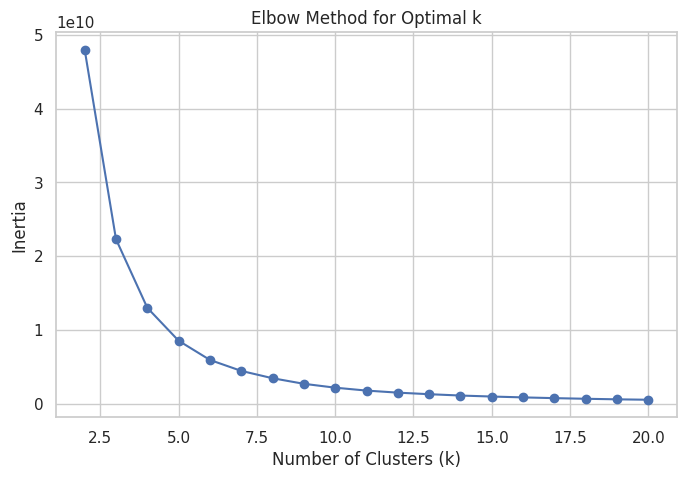

In [ ]:
# ================================
# Task 3.1: Elbow Method (FINAL FIX)
# ================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ai/dataset_scaled.csv')

# Keep only numeric columns
X = df.select_dtypes(include=['int64', 'float64'])

print("Original shape:", X.shape)
print("Missing values before imputation:", X.isna().sum().sum())

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

print("Missing values after imputation:",
      pd.DataFrame(X_imputed).isna().sum().sum())

# Elbow Method
inertia = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_imputed)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [ ]:
# ================================
# Task 3.2: K-Means Clustering
# ================================

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ai/dataset_scaled.csv')

# Keep only numeric columns for clustering
X = df.select_dtypes(include=['int64', 'float64'])

# Handle missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Apply K-Means with optimal k = 5
kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X_imputed)

# Add cluster labels to the original dataframe
df['cluster_kmeans'] = cluster_labels

# Display first few rows
df[['cluster_kmeans']].head()

,cluster_kmeans
0,2
1,2
2,2
3,2
4,2


In [ ]:
# ================================
# Task 3.3: DBSCAN Clustering
# ================================

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ai/dataset_scaled.csv')

# Keep numeric columns only
X = df.select_dtypes(include=['int64', 'float64'])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# (Optional but recommended) scale again for DBSCAN stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Use a random subset (20%) for DBSCAN due to computational cost
X_sample = pd.DataFrame(X_scaled).sample(frac=0.2, random_state=42)

# Apply DBSCAN
dbscan = DBSCAN(
    eps=1.5,
    min_samples=10,
    n_jobs=-1
)

dbscan_labels = dbscan.fit_predict(X_sample)

# Add DBSCAN labels to sampled dataframe
X_sample['cluster_dbscan'] = dbscan_labels

# View cluster distribution
X_sample['cluster_dbscan'].value_counts().sort_index()


,count
cluster_dbscan,
-1,21290
0,141
1,56
2,15
3,122
...,...
189,13
190,10
191,10


In [ ]:
print(df.columns)

Index(['activity_id', 'activity_name', 'activity_encoded', 'subject_file',
       'timestamp', 'heart_rate', 'hand_temperature', 'hand_acc16g_x',
       'hand_acc16g_y', 'hand_acc16g_z', 'hand_acc6g_x', 'hand_acc6g_y',
       'hand_acc6g_z', 'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z',
       'hand_mag_x', 'hand_mag_y', 'hand_mag_z', 'hand_orientation_1',
       'hand_orientation_2', 'hand_orientation_3', 'hand_orientation_4',
       'chest_temperature', 'chest_acc16g_x', 'chest_acc16g_y',
       'chest_acc16g_z', 'chest_acc6g_x', 'chest_acc6g_y', 'chest_acc6g_z',
       'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x',
       'chest_mag_y', 'chest_mag_z', 'chest_orientation_1',
       'chest_orientation_2', 'chest_orientation_3', 'chest_orientation_4',
       'ankle_temperature', 'ankle_acc16g_x', 'ankle_acc16g_y',
       'ankle_acc16g_z', 'ankle_acc6g_x', 'ankle_acc6g_y', 'ankle_acc6g_z',
       'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x',
       'ankle

In [ ]:
# ================================
# Task 3.4: Clustering Metrics
# (Correct label column)
# ================================

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ai/dataset_scaled.csv')

# -------------------------------
# Feature matrix
# -------------------------------
X = df.select_dtypes(include=['int64', 'float64'])

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# -------------------------------
# TRUE LABELS
# -------------------------------
y_true = df['activity_encoded']

# -------------------------------
# K-MEANS (recomputed for safety)
# -------------------------------
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_imputed)

# -------------------------------
# METRICS
# -------------------------------
sil_kmeans = silhouette_score(X_imputed, kmeans_labels)
ari_kmeans = adjusted_rand_score(y_true, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y_true, kmeans_labels)

print("K-Means Clustering Metrics")
print("---------------------------")
print("Silhouette Score:", round(sil_kmeans, 4))
print("ARI:", round(ari_kmeans, 4))
print("NMI:", round(nmi_kmeans, 4))


K-Means Clustering Metrics
---------------------------
Silhouette Score: 0.5441
ARI: 0.1915
NMI: 0.4548


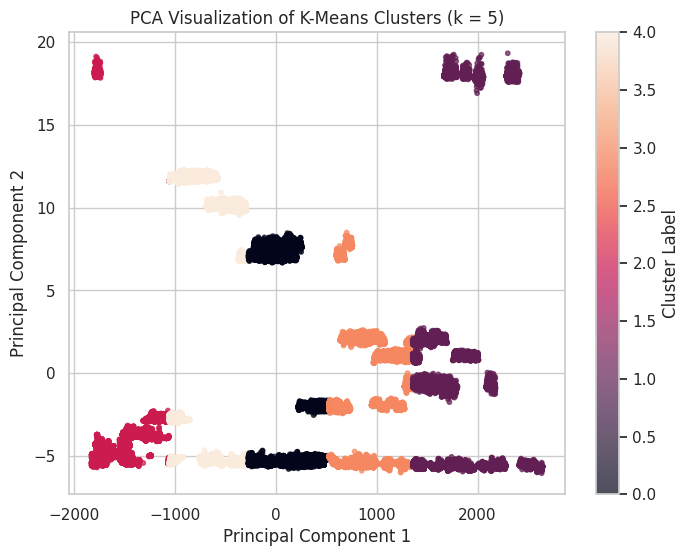

In [ ]:
# ================================
# Task 3.5: PCA Visualization
# ================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ai/dataset_scaled.csv')

# -------------------------------
# Feature matrix
# -------------------------------
X = df.select_dtypes(include=['int64', 'float64'])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# -------------------------------
# Recompute K-Means (k = 5)
# -------------------------------
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_imputed)

# -------------------------------
# PCA to 2 dimensions
# -------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_imputed)

# -------------------------------
# Plot PCA with cluster colors
# -------------------------------
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters,
    s=10,
    alpha=0.7
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of K-Means Clusters (k = 5)')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

In [ ]:
# ================================
# Task 3.6: Feature Importance
# (Self-contained version)
# ================================

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ai/dataset_scaled.csv')

# -------------------------------
# Features and target
# -------------------------------
X = df.select_dtypes(include=['int64', 'float64'])
y = df['activity_encoded']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# -------------------------------
# Train Random Forest
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_imputed, y)

# -------------------------------
# Feature importance
# -------------------------------
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# Display top 15 features
feature_importance.head(15)

,0
activity_id,0.272875
activity_encoded,0.218922
timestamp,0.108883
chest_acc6g_z,0.031760
chest_acc16g_z,0.027285
hand_temperature,0.024240
chest_temperature,0.020864
chest_mag_z,0.015963
chest_acc16g_y,0.015709
chest_mag_y,0.015319


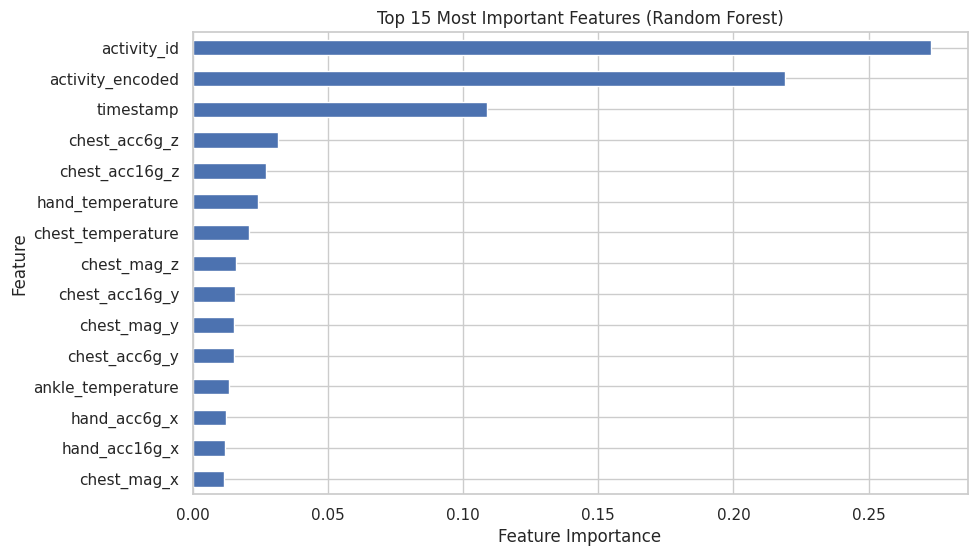

In [ ]:
# ================================
# Task 3.7: Feature Importance Plot
# ================================

import matplotlib.pyplot as plt

# Select top 15 features
top_features = feature_importance.head(15)

# Plot
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.grid(True)
plt.show()